# Phrases

In [10]:
import os
import pandas as pd

# Base columns to keep
col_names = ['task', 'seed']  # hyperparameters dropped
datasets = ["Crowd", "Students", "LLM", "Experts"]
methods = ["MvP", "Paraphrase", "LLM-FS", "LLM-FT"]
all_runs = []

for dataset in datasets:
    for method in methods:
        RESULTS_PATH = os.path.join(f"../../methods/{method}/", dataset)
        folder_names = [
            folder for folder in os.listdir(RESULTS_PATH)
            if os.path.isdir(os.path.join(RESULTS_PATH, folder))
            and folder != '.ipynb_checkpoints'
            and folder != 'duplicate_labels'
            and "acsa" not in folder.lower()
        ]

        for folder_name in folder_names:
            try:
                cond_parameters = folder_name.split('_')  # gives task, seed, etc.
                # print(folder_name)
                if method == "LLM-FS":
                    if not folder_name.__contains__("tasd"):
                        df = pd.read_csv(
                            os.path.join(RESULTS_PATH, folder_name, 'result_phrases.tsv'),
                            sep='\t'
                        )
                        df_small = df[['Unnamed: 0', 'f1']].rename(columns={'Unnamed: 0': 'label'})
                else:
                    df = pd.read_csv(
                    os.path.join(RESULTS_PATH, folder_name, 'metrics_phrases.tsv'),
                    sep='\t')
                    df_small = df[['Unnamed: 0', 'f1']].rename(columns={'Unnamed: 0': 'label'})


                # Keep only label + f1
                
                
                # Add task + seed + dataset info
                df_small['task'] = cond_parameters[0] if len(cond_parameters) > 0 else None
                df_small['seed'] = cond_parameters[-1] if cond_parameters[-1].isdigit() else None
                df_small['dataset'] = dataset
                df_small['method'] = method

                all_runs.append(df_small)
            except Exception as e:
                print(f"Skipping {folder_name} in {dataset}: {e}")

# Concatenate everything
results_all = pd.concat(all_runs, ignore_index=True)

# Convert numeric
results_all["f1"] = pd.to_numeric(results_all["f1"], errors="coerce")
# Drop Micro/Macro rows
results_all = results_all[~results_all["label"].str.contains("AVG")]

# display(results_all)

results_avg = (
    results_all
    .groupby(["dataset", "task", "label", "method"], as_index=False)["f1"]
    .mean()
)

# Save to new dataframe (already done, but here we keep both)
print("Original:", results_all.shape)
print("Averaged:", results_avg.shape)

display(results_avg)

Original: (400, 6)
Averaged: (80, 5)


,dataset,task,label,method,f1
0,Crowd,tasd,ambiente,LLM-FS,0.560000
1,Crowd,tasd,ambiente,LLM-FT,0.692840
2,Crowd,tasd,ambiente,MvP,0.561440
3,Crowd,tasd,ambiente,Paraphrase,0.523825
4,Crowd,tasd,essen,LLM-FS,0.551300
...,...,...,...,...,...
75,Students,tasd,preis,Paraphrase,0.287400
76,Students,tasd,service,LLM-FS,0.638100
77,Students,tasd,service,LLM-FT,0.693480
78,Students,tasd,service,MvP,0.652740


# Phrases

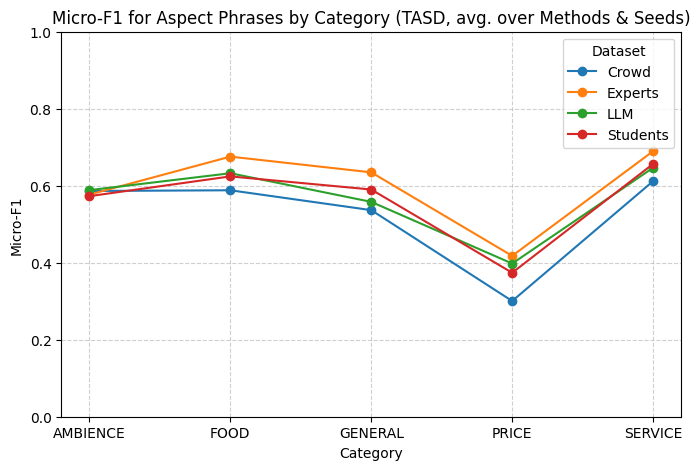

In [15]:
import matplotlib.pyplot as plt

category_map = {
    "essen": "FOOD",
    "service": "SERVICE",
    "gesamteindruck": "GENERAL",
    "ambiente": "AMBIENCE",
    "preis": "PRICE"
}

results_all["label"] = results_all["label"].replace(category_map)
acsa_only = results_all[results_all["task"].str.contains("tasd")]

# Average over seeds + datasets for each (method, category, polarity)
acsa_avg = (
    acsa_only
    .groupby(["dataset", "label"], as_index=False)["f1"]
    .mean()
)

categories = ["essen", "service", "gesamteindruck", "ambiente", "preis"]

# --- Separate plots per polarity ---
plt.figure(figsize=(8, 5))
for dataset in acsa_avg["dataset"].unique():
    subset = acsa_avg[acsa_avg["dataset"] == dataset]
    plt.plot(
        subset["label"], subset["f1"], marker="o", label=dataset
    )

plt.title("Micro-F1 for Aspect Phrases by Category (TASD, avg. over Methods & Seeds)")
plt.xlabel("Category")
plt.ylabel("Micro-F1")
plt.ylim(0, 1)
plt.legend(title="Dataset")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("appendix_phrase_performance_tasd.pdf", bbox_inches="tight")
plt.show()
